In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [3]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [4]:
import malaya_speech
import malaya_speech.config
import malaya_speech.augmentation.waveform as augmentation
import malaya_speech.train.model.unet_enhancement as unet
from malaya_speech.train.model import enhancement
from malaya_speech.utils import tf_featurization
import tensorflow as tf
import numpy as np






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





In [5]:
sr = 22050
partition_size = 4096
length = 5500

In [6]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None,))
x_ = tf.expand_dims(x, 1)
partitioned_x = tf_featurization.pad_and_partition(x_, partition_size)
model = unet.Model(partitioned_x, channels_interval = 24)

model.logits.set_shape((None, partition_size, 1))
logits = tf.reshape(model.logits, (-1, 1))
logits = logits[:tf.shape(x)[0], 0]

logits = tf.identity(logits, name = 'logits')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Tensor("strided_slice_3:0", shape=(?, 2048, 24), dtype=float32)
Tensor("strided_slice_4:0", shape=(?, 1024, 48), dtype=float32)
Tensor("strided_slice_5:0", shape=(?, 512, 72), dtype=float32)
Tensor("strided_slice_6:0", shape=(?, 256, 96), dtype=float32)
Tensor("strided_slice_7:0", shape=(?, 128, 120), dtype=float32)
Tensor("strided_slice_8:0", shape=(?, 64, 144), dtype=float32)
Tensor("strided_slice_9:0", shape=(?, 32, 168), dtype=float32)
Tensor("strided_slice_10:0", shape=(?, 16, 192), dtype=float32)
Tensor("strided_slice_11:0", shape=(?, 8, 216), dtype=float32)
Tensor("strided_slice_12:0", shape=(?, 4, 240), dtype=float32)
Tensor("strided_slice_13:0", shape=(?, 2, 264), dtype=float32)
Tensor("strided_slice_14:0", shape=(?, 1, 288), dtype=float32)
Tensor("sequential_12/leaky_re_lu_12/LeakyRelu:0", shape=(?, 1, 288), dtype=float32)
Tensor("sequential_13/leaky_re_lu_13/LeakyRelu:0", shape=(?, 2, 288), dtyp

In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [8]:
path = 'speech-enhancement-unet-24'
ckpt_path = tf.train.latest_checkpoint(path)
ckpt_path

'speech-enhancement-unet-24/model.ckpt-3500000'

In [9]:
var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
saver = tf.train.Saver(var_list = var_list)
saver.restore(sess, ckpt_path)

INFO:tensorflow:Restoring parameters from speech-enhancement-unet-24/model.ckpt-3500000


In [10]:
import IPython.display as ipd
import museval
import matplotlib.pyplot as plt
from glob import glob

In [11]:
def get_pair(f):
    return f.split('/')[-1].split('-')[0]


def read_wav(f):
    return malaya_speech.load(f, sr = sr)

In [14]:
Y = glob('testset-speech-enhancement/*-y.wav')

In [15]:
from tqdm import tqdm
from glob import glob

sdrs, isrs, sars = [], [], []

for y in tqdm(Y):
    y_ = f'testset-speech-enhancement/{get_pair(y)}-y_.wav'
    y, _ = read_wav(y)
    y_, _ = read_wav(y_)
    y__ = sess.run(logits, feed_dict = {x: y_})
    sdr, isr, _, sar = museval.evaluate(np.expand_dims(y__, 0), 
                                    np.expand_dims(y, 0))
    sdrs.append(np.nanmean(sdr))
    isrs.append(np.nanmean(isr))
    sars.append(np.nanmean(sar))

100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


In [16]:
np.mean(sdrs), np.mean(isrs), np.mean(sars)

(9.877178489869546, 15.91621736537076, 13.709130647551937)

In [17]:
l, sr_ = malaya_speech.load('wadi-annuar.wav', sr = sr)
len(l) / sr_, sr_

(10.0, 22050)

In [18]:
ipd.Audio(l, rate = sr_)

In [19]:
y_ = sess.run(logits, feed_dict = {x: l})

In [20]:
ipd.Audio(y_, rate = sr_)

/home/husein/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


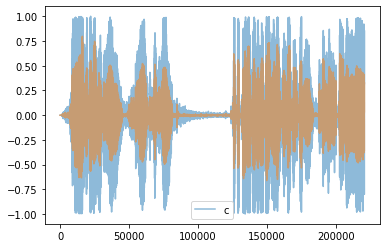

In [21]:
plt.plot(l, alpha = 0.5, label = 'c')
plt.plot(y_, alpha = 0.5)
plt.legend()
plt.show()

In [22]:
saver = tf.train.Saver()
saver.save(sess, 'speech-enhancement-24/model.ckpt')

'speech-enhancement-24/model.ckpt'

In [23]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or 'logits' in n.name)
        and 'adam' not in n.name
        and 'beta' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
    ]
)
strings.split(',')

['Placeholder',
 'sequential/conv1d/kernel/Read/ReadVariableOp',
 'sequential/conv1d/bias/Read/ReadVariableOp',
 'sequential/conv1d/conv1d/ExpandDims_1/ReadVariableOp',
 'sequential/conv1d/BiasAdd/ReadVariableOp',
 'sequential/batch_normalization/gamma/Read/ReadVariableOp',
 'sequential/batch_normalization/moving_mean/Read/ReadVariableOp',
 'sequential/batch_normalization/moving_variance/Read/ReadVariableOp',
 'sequential/batch_normalization/batchnorm/mul/ReadVariableOp',
 'sequential/batch_normalization/batchnorm/ReadVariableOp',
 'sequential_1/conv1d_1/kernel/Read/ReadVariableOp',
 'sequential_1/conv1d_1/bias/Read/ReadVariableOp',
 'sequential_1/conv1d_1/conv1d/ExpandDims_1/ReadVariableOp',
 'sequential_1/conv1d_1/BiasAdd/ReadVariableOp',
 'sequential_1/batch_normalization_1/gamma/Read/ReadVariableOp',
 'sequential_1/batch_normalization_1/moving_mean/Read/ReadVariableOp',
 'sequential_1/batch_normalization_1/moving_variance/Read/ReadVariableOp',
 'sequential_1/batch_normalization_1/b

In [24]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [25]:
freeze_graph('speech-enhancement-24', strings)

INFO:tensorflow:Restoring parameters from speech-enhancement-24/model.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 152 variables.
INFO:tensorflow:Converted 152 variables to const ops.
1320 ops in the final graph.


In [26]:
def load_graph(frozen_graph_filename, **kwargs):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # https://github.com/onnx/tensorflow-onnx/issues/77#issuecomment-445066091
    # to fix import T5
    for node in graph_def.node:
        if node.op == 'RefSwitch':
            node.op = 'Switch'
            for index in xrange(len(node.input)):
                if 'moving_' in node.input[index]:
                    node.input[index] = node.input[index] + '/read'
        elif node.op == 'AssignSub':
            node.op = 'Sub'
            if 'use_locking' in node.attr:
                del node.attr['use_locking']
        elif node.op == 'AssignAdd':
            node.op = 'Add'
            if 'use_locking' in node.attr:
                del node.attr['use_locking']
        elif node.op == 'Assign':
            node.op = 'Identity'
            if 'use_locking' in node.attr:
                del node.attr['use_locking']
            if 'validate_shape' in node.attr:
                del node.attr['validate_shape']
            if len(node.input) == 2:
                node.input[0] = node.input[1]
                del node.input[1]

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [27]:
g = load_graph('speech-enhancement-24/frozen_model.pb')
x = g.get_tensor_by_name('import/Placeholder:0')
logits = g.get_tensor_by_name('import/logits:0')

In [28]:
test_sess = tf.InteractiveSession(graph = g)

/home/husein/.local/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [29]:
y_ = test_sess.run(logits, feed_dict = {x: l})

In [30]:
ipd.Audio(y_, rate = sr)

In [31]:
from tensorflow.tools.graph_transforms import TransformGraph

pb = 'speech-enhancement-24/frozen_model.pb'

transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-1024, fallback_max=1024)',
             'strip_unused_nodes',
             'sort_by_execution_order']

input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           ['Placeholder'],
                                           ['logits'], transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

Instructions for updating:
Use tf.gfile.GFile.


In [32]:
g = load_graph('speech-enhancement-24/frozen_model.pb.quantized')
x = g.get_tensor_by_name('import/Placeholder:0')
logits = g.get_tensor_by_name('import/logits:0')
test_sess = tf.InteractiveSession(graph = g)

In [33]:
y_ = test_sess.run(logits, feed_dict = {x: l})
ipd.Audio(y_, rate = sr)